In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Corpus -> Genre Mapping

'OS_Doc2_The-Lego-Movie.docx', ==> Animation, Action, Adventure, Comedy, Family, Fantasy
'TAM_Doc2_The_Hateful_Eight.docx', ==> Crime, Drama, Mystery, Thriller, Western
'EH_Doc1_A-Masterpiece-best-action-sci-fi-classic-film.docx', ==> Action, Adventure, Sci-Fi, Thriller
'VP_Doc1_Blade-Runner.docx', ==> Action, Sci-Fi, Thriller
'TAM_Doc1_Reservoir_Dogs_1992.docx', ==> Crime, Drama, Thriller
'BDL_Doc2_Blade-Runner-2049.docx', ==> Action, Drama, Mystery, Sci-Fi, Thriller
'JC_Doc2_Terminator-Judgement-Day.docx', ==> Action, Sci-Fi
'EH_Doc2_Arnie-is-at his-best-in-this sci-fi-classic.docx', ==> Action, Adventure, Sci-Fi, Thriller
'OHU_Doc2_Parasite.docx', ==> Comedy, Drama, Thriller
'JM_Doc2__Anchorman__delivers_comedic_goods.docx', ==> Comedy
'YG_Doc1_Frozen.docx', ==> Animation, Adventure, Comedy, Family, Fantasy, Musical
'HK_Doc1_Dreams_Subconscious_Minds.docx', ==> Action, Adventure, Sci-Fi, Thriller
'VP_Doc2_Blade-Runner-2049.docx', ==> Action, Drama, Mystery, Sci-Fi, Thriller
'MAM_Doc1_Tommy-Boy.docx', ==> Adventure, Comedy
'RSM_Doc2_Billy-Bob-Guzzles.docx', ==> Comedy, Sport
'HK_Doc2_Dreams_Subconscious_Minds.docx', ==> Action, Adventure, Sci-Fi, Thriller
'BDL_Doc1_Great-Scott.docx',  ==> Action, Drama, Mystery, Sci-Fi, Thriller
'JM_Doc1_Big_Daddy.docx', ==> Comedy, Drama
'RSM_Doc1_Bad-News-Bears.docx', ==> Comedy, Sport
'CEM_Doc1_50_First_Dates.docx', ==> Comedy, Drama, Romance
'JC_Doc1_AI-Artificial-Intelligence.docx', ==> Drama, Sci-Fi
'OHU_Doc1_Sorry-To-Bother.docx', ==> Comedy, Fantasy, Sci-Fi
'CEM_Doc2_Just_Go_With.docx', ==> Comedy, Romance
'OS_Doc1_Finding-Nemo.docx', ==> Animation, Adventure, Comedy, Family
'MAM_Doc2_Dumb-and-Dumber.docx', ==> Comedy
'YG_Doc2_Monsters-University.docx' ==> Animation, Adventure, Comedy, Family, Fantasy

In [1070]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import docx
import itertools
import os
import numpy as np
from collections import defaultdict
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import hamming_loss

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/trevor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/trevor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data

In [927]:
df_corpus = pd.read_csv('./data/corpus.csv')
df_corpus

,Unnamed: 0,DSI_Title,Text
0,0,JC_Doc1_AI-Artificial-Intelligence.docx,Greatness and miscalculation fight for screen ...
1,1,EH_Doc2_Arnie-is-at his-best-in-this sci-fi-cl...,Arnie is at his best in this sci-fi classic! \...
2,2,BDL_Doc1_Great-Scott.docx,"In an earlier review of ""Blade Runner,"" I wrot..."
3,3,YPL_Doc2_The_Farewell.docx,The Farewell rips your heart out of your chest...
4,4,KWB_Doc2_Artemis-Fowl-Review.docx,It took 20 years for an “Artemis Fowl” movie t...
...,...,...,...
59,59,OS_Doc2_The-Lego-Movie.docx,After successfully testing the computer-animat...
60,60,DB_Doc2_Jordan_Peele_s_Us.docx,"Us, as soon as you’ve shaken off the chills it..."
61,61,AEJ_Doc1_Review_how_to.docx,There are moments in the “How to Train Your Dr...
62,62,JM_Doc1_Big_Daddy.docx,"""Big Daddy"" is a film about a seriously distur..."


In [928]:
class_mapping = {doc: None for doc in df_corpus['DSI_Title']}
class_mapping

{'JC_Doc1_AI-Artificial-Intelligence.docx': None,
 'EH_Doc2_Arnie-is-at his-best-in-this sci-fi-classic.docx': None,
 'BDL_Doc1_Great-Scott.docx': None,
 'YPL_Doc2_The_Farewell.docx': None,
 'KWB_Doc2_Artemis-Fowl-Review.docx': None,
 'CEY_Doc1_The-Lion-King.docx': None,
 'YG_Doc2_Monsters-University.docx': None,
 'MMC_DOC1_Boston_Herland_1917.docx': None,
 'TJ_Doc1_ESOTSM.docx': None,
 'KV_Doc1_In-Get-Out.docx': None,
 'YC_Doc1_Blade-Runner-Review.docx': None,
 'BDL_Doc2_Blade-Runner-2049.docx': None,
 'AH_Doc2_Coco Brings the.docx': None,
 'RSM_Doc1_Bad-News-Bears.docx': None,
 'AH_Doc1_Coco review charmer.docx': None,
 'RSM_Doc2_Billy-Bob-Guzzles.docx': None,
 'CEY_Doc2_The-Lion-King.docx': None,
 'MS_Doc2_Why I Left ‘Knives Out’ With Emotional Whiplash.docx': None,
 'DLC_DOC1_Parasite_Review_Pleasures.docx': None,
 'JM_Doc2__Anchorman__delivers_comedic_goods.docx': None,
 'TAM_Doc1_Reservoir_Dogs_1992.docx': None,
 'OHU_Doc2_Parasite.docx': None,
 'MT_Doc1_With_Frozen2_Disney.docx'

Action, Adventure, Comedy, Sci-Fi, Drama, Thriller, Family, Animation

In [936]:
class_mapping['OS_Doc2_The-Lego-Movie.docx'] = ['Action', 'Adventure', 'Comedy', 'Animation', 'Family']
class_mapping['TAM_Doc2_The_Hateful_Eight.docx'] = ['Drama', 'Thriller']
class_mapping['EH_Doc1_A-Masterpiece-best-action-sci-fi-classic-film.docx'] = ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
class_mapping['VP_Doc1_Blade-Runner.docx'] = ['Action', 'Sci-Fi', 'Thriller']
class_mapping['TAM_Doc1_Reservoir_Dogs_1992.docx'] = ['Drama', 'Thriller']
class_mapping['BDL_Doc2_Blade-Runner-2049.docx'] = ['Action', 'Drama', 'Sci-Fi', 'Thriller']
class_mapping['JC_Doc2_Terminator-Judgement-Day.docx'] = ['Action', 'Sci-Fi']
class_mapping['EH_Doc2_Arnie-is-at his-best-in-this sci-fi-classic.docx'] = ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
class_mapping['OHU_Doc2_Parasite.docx'] = ['Comedy', 'Drama', 'Thriller']
class_mapping['JM_Doc2__Anchorman__delivers_comedic_goods.docx'] = ['Comedy']
class_mapping['YG_Doc1_Frozen.docx'] = ['Action', 'Adventure', 'Comedy', 'Family']
class_mapping['HK_Doc1_Dreams_Subconscious_Minds.docx'] = ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
class_mapping['VP_Doc2_Blade-Runner-2049.docx'] = ['Action', 'Drama', 'Sci-Fi', 'Thriller']
class_mapping['MAM_Doc1_Tommy-Boy.docx'] = ['Adventure', 'Comedy']
class_mapping['RSM_Doc2_Billy-Bob-Guzzles.docx'] = ['Comedy']
class_mapping['HK_Doc2_Dreams_Subconscious_Minds.docx'] = ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
class_mapping['BDL_Doc1_Great-Scott.docx'] = ['Action', 'Drama', 'Sci-Fi', 'Thriller']
class_mapping['JM_Doc1_Big_Daddy.docx'] = ['Comedy', 'Drama']
class_mapping['RSM_Doc1_Bad-News-Bears.docx'] = ['Comedy']
class_mapping['CEM_Doc1_50_First_Dates.docx'] = ['Comedy', 'Drama']
class_mapping['JC_Doc1_AI-Artificial-Intelligence.docx'] = ['Drama', 'Sci-Fi']
class_mapping['OHU_Doc1_Sorry-To-Bother.docx'] = ['Comedy', 'Sci-Fi']
class_mapping['CEM_Doc2_Just_Go_With.docx'] = ['Comedy']
class_mapping['OS_Doc1_Finding-Nemo.docx'] = ['Comedy', 'Animation', 'Adventure', 'Family']
class_mapping['MAM_Doc2_Dumb-and-Dumber.docx'] = ['Comedy']
class_mapping['YG_Doc2_Monsters-University.docx'] = ['Comedy', 'Animation', 'Adventure', 'Family']

class_mapping['YPL_Doc2_The_Farewell.docx'] = ['Comedy', 'Drama']
class_mapping['KWB_Doc2_Artemis-Fowl-Review.docx'] = ['Adventure', 'Sci-Fi']
class_mapping['CEY_Doc1_The-Lion-King.docx'] = ['Animation', 'Adventure', 'Drama', 'Family']
class_mapping['MMC_DOC1_Boston_Herland_1917.docx'] = ['Drama']
class_mapping['TJ_Doc1_ESOTSM.docx'] = ['Drama', 'Sci-Fi']
class_mapping['KV_Doc1_In-Get-Out.docx'] = ['Thriller']
class_mapping['YC_Doc1_Blade-Runner-Review.docx'] = ['Action', 'Sci-Fi', 'Thriller']
class_mapping['AH_Doc2_Coco Brings the.docx'] = ['Animation', 'Adventure', 'Family']
class_mapping['AH_Doc1_Coco review charmer.docx'] = ['Animation', 'Adventure', 'Family']
class_mapping['CEY_Doc2_The-Lion-King.docx'] = ['Animation', 'Adventure', 'Drama', 'Family']
class_mapping['MS_Doc2_Why I Left ‘Knives Out’ With Emotional Whiplash.docx'] = ['Drama']
class_mapping['DLC_DOC1_Parasite_Review_Pleasures.docx'] = ['Comedy', 'Drama', 'Thriller']
class_mapping['MT_Doc1_With_Frozen2_Disney.docx'] = ['Action', 'Adventure', 'Comedy', 'Family']
class_mapping['YC_Doc2_Futuristic-Blade-Runner.docx'] = ['Action', 'Drama', 'Sci-Fi', 'Thriller']
class_mapping['EC_Doc1_Garden-State-Was.docx'] = ['Comedy', 'Drama']
class_mapping['XL_Doc2_Secrect-life-pets.docx'] = ['Animation', 'Adventure', 'Comedy', 'Family']
class_mapping['MS_Doc1_Knives Out’ Review Murder Most Clever.docx'] = ['Comedy', 'Drama', 'Thriller']
class_mapping['SPC_Doc2_Parents-Need_Know.docx'] = ['Animation', 'Adventure', 'Comedy', 'Family']
class_mapping['YPL_Doc1_The_Farewell.docx'] = ['Comedy', 'Drama']
class_mapping['XL_Doc1_Secret-life-Pets.docx'] = ['Animation', 'Adventure', 'Comedy', 'Family']
class_mapping['TJ_Doc2_ESOTSM.docx'] = ['Drama', 'Sci-Fi']
class_mapping['AEJ_Doc2_How_to_Train.docx'] = ['Animation', 'Action', 'Adventure', 'Family']
class_mapping['SXN_Doc1_Hidden Figures.docx'] = ['Drama']
class_mapping['SXN_Doc2_Hidden Figures (NYT).docx'] = ['Drama'] 
class_mapping['EC_Doc2_But-a-year.docx'] = ['Comedy', 'Drama']
class_mapping['DB_Doc1_Get_Out_Review.docx'] = ['Thriller']
class_mapping['JKS_Doc2_The-Hobbit_-An.docx'] = ['Adventure']
class_mapping['SPC_Doc1_Moana-Daughter-Chief.docx'] = ['Animation', 'Adventure', 'Comedy', 'Family']
class_mapping['LAR_Doc2_Lord_Ring_Return.docx'] = ['Adventure', 'Drama']
class_mapping['LAR_Doc1_Lord_Ring_Fellowship.docx'] = ['Adventure', 'Drama']
class_mapping['JKS_Doc1_The-Lord-of.docx'] = ['Adventure', 'Drama']
class_mapping['DLC_DOC2_Parasite_Gisaengchung_Film.docx'] = ['Comedy', 'Drama', 'Thriller']
class_mapping['KWB_Doc1_Artemis-Fowl-Review.docx'] = ['Adventure', 'Sci-Fi']
class_mapping['MT_Doc2_New_Storm_Frozen2.docx'] = ['Action', 'Adventure', 'Comedy', 'Family']
class_mapping['KV_Doc2_Anyone-who-cares.docx'] = ['Comedy']
class_mapping['DB_Doc2_Jordan_Peele_s_Us.docx'] = ['Thriller']
class_mapping['AEJ_Doc1_Review_how_to.docx'] = ['Animation', 'Action', 'Adventure', 'Family']
class_mapping['MMC_DOC2_NewYorker_1917.docx'] = ['Drama']

In [938]:
class_mapping_int = {
    'Action': 0,
    'Comedy': 1,
    'Drama': 2,
    'Adventure': 3,
    'Animation': 4,
    'Sci-Fi': 5,
    'Thriller': 6,
    'Family': 7
}

In [1111]:
with open('./data/document_label_pairs.data', 'wb') as handle:
    pickle.dump(class_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)  

# Generating our k-fold cross-validation sets

In [941]:
len(class_mapping) * .25

16.0

In [966]:
k = 16

folds = defaultdict()

for i in range(k):
    # Need to draw 2 numbers without replacement
    idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8, idx9, idx10, idx11, idx12, idx13, idx14, idx15, idx16 = np.random.randint(0, len(tokens_dict), 16)
    
    # If our drawn indexes are the same
    while len(np.unique([idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8, idx9, idx10, idx11, idx12, idx13, idx14, idx15, idx16])) != 16:
        idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8, idx9, idx10, idx11, idx12, idx13, idx14, idx15, idx16 = np.random.randint(0, len(tokens_dict), 16)
        
    folds[i] = defaultdict()
    folds[i]['docs'] = [list(class_mapping.keys())[idx1],
                        list(class_mapping.keys())[idx2],
                        list(class_mapping.keys())[idx3],
                        list(class_mapping.keys())[idx4],
                        list(class_mapping.keys())[idx5],
                        list(class_mapping.keys())[idx6],
                        list(class_mapping.keys())[idx7],
                        list(class_mapping.keys())[idx8],
                       list(class_mapping.keys())[idx9],
                       list(class_mapping.keys())[idx10],
                       list(class_mapping.keys())[idx11],
                       list(class_mapping.keys())[idx12],
                       list(class_mapping.keys())[idx13],
                       list(class_mapping.keys())[idx14],
                       list(class_mapping.keys())[idx15],
                       list(class_mapping.keys())[idx16]]
    
    folds[i]['idxs'] = [idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8, idx9, idx10, idx11, idx12, idx13, idx14, idx15, idx16]

In [967]:
folds

defaultdict(None,
            {0: defaultdict(None,
                         {'docs': ['DB_Doc1_Get_Out_Review.docx',
                           'MS_Doc2_Why I Left ‘Knives Out’ With Emotional Whiplash.docx',
                           'KV_Doc2_Anyone-who-cares.docx',
                           'CEY_Doc1_The-Lion-King.docx',
                           'AEJ_Doc2_How_to_Train.docx',
                           'VP_Doc2_Blade-Runner-2049.docx',
                           'JKS_Doc2_The-Hobbit_-An.docx',
                           'YG_Doc1_Frozen.docx',
                           'AH_Doc1_Coco review charmer.docx',
                           'TJ_Doc1_ESOTSM.docx',
                           'CEY_Doc2_The-Lion-King.docx',
                           'EC_Doc2_But-a-year.docx',
                           'YG_Doc2_Monsters-University.docx',
                           'KV_Doc1_In-Get-Out.docx',
                           'LAR_Doc1_Lord_Ring_Fellowship.docx',
                           'MAM_Doc1_To

In [944]:
with open('./data/folds.data', 'wb') as handle:
    pickle.dump(folds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Utils

In [945]:
def tokenize_docx(path):
    """
    Args:
        path (str)
    """
    if not os.path.isfile(path):
        raise FileNotFoundError('Given path does not exist.')
        
    read_in = docx.Document(path)
    read_in = [p.text for p in read_in.paragraphs]
    read_in = [x.split() for x in read_in]
    return [i for sub in read_in for i in sub]

In [946]:
def clean_tokens(tokens, stem=False, lemma=False):
    """"""
    punctuation = re.compile('[%s]' % re.escape(string.punctuation))
    de_punct = [punctuation.sub('', w) for w in tokens]
    alpha = [w for w in de_punct if w.isalpha()]
    lower = [x.lower() for x in de_punct]
    stops = set(stopwords.words('english'))
    tokens = [w for w in lower if not w in stops]
    
    if stem:
        stemmer = PorterStemmer()
        return [stemmer.stem(w) for w in tokens]
    
    elif lemma:
        lemmer = WordNetLemmatizer()
        return [lemmer.lemmatize(w) for w in tokens]
    
    else:
        return tokens

In [948]:
df_corpus

,Unnamed: 0,DSI_Title,Text
0,0,JC_Doc1_AI-Artificial-Intelligence.docx,Greatness and miscalculation fight for screen ...
1,1,EH_Doc2_Arnie-is-at his-best-in-this sci-fi-cl...,Arnie is at his best in this sci-fi classic! \...
2,2,BDL_Doc1_Great-Scott.docx,"In an earlier review of ""Blade Runner,"" I wrot..."
3,3,YPL_Doc2_The_Farewell.docx,The Farewell rips your heart out of your chest...
4,4,KWB_Doc2_Artemis-Fowl-Review.docx,It took 20 years for an “Artemis Fowl” movie t...
...,...,...,...
59,59,OS_Doc2_The-Lego-Movie.docx,After successfully testing the computer-animat...
60,60,DB_Doc2_Jordan_Peele_s_Us.docx,"Us, as soon as you’ve shaken off the chills it..."
61,61,AEJ_Doc1_Review_how_to.docx,There are moments in the “How to Train Your Dr...
62,62,JM_Doc1_Big_Daddy.docx,"""Big Daddy"" is a film about a seriously distur..."


In [949]:
tokens_dict = defaultdict()

for i in range(len(df_corpus)):
    tokens_dict[df_corpus['DSI_Title'][i]] = df_corpus['Text'][i].split()

In [951]:
for doc in tokens_dict.keys():
    tokens_dict[doc] = clean_tokens(tokens=tokens_dict[doc], lemma=True)

# Qualitative Approach

In [5]:
doc_list = os.listdir('../corpus/class_corpus/')

In [25]:
tokens_dict = defaultdict()

for doc in doc_list:
    tokens_dict[doc] = defaultdict()
    tokens_dict[doc]['tokens'] = tokenize_docx(path=os.path.join('../corpus/class_corpus',doc))
    tokens_dict[doc]['token_cnt'] = defaultdict()

In [26]:
for doc in tokens_dict.keys():
    tokens_dict[doc]['tokens'] = clean_tokens(tokens=tokens_dict[doc]['tokens'], lemma=True)

In [27]:
for doc in tokens_dict.keys():
    for w in np.unique(tokens_dict[doc]['tokens']):
        tokens_dict[doc]['token_cnt'][w] = tokens_dict[doc]['tokens'].count(w)

In [31]:
tokens_dict

defaultdict(None,
            {'OS_Doc2_The-Lego-Movie.docx': defaultdict(None,
                         {'tokens': ['successfully',
                           'testing',
                           'computeranimated',
                           'water',
                           'smaller',
                           'screen',
                           'like',
                           'lego',
                           'star',
                           'war',
                           'lego',
                           'ninjago',
                           'mention',
                           'series',
                           'hit',
                           'video',
                           'game',
                           'everybody’s',
                           'favorite',
                           'danish',
                           'interlocking',
                           'brick',
                           'system',
                           'finally',
       

In [256]:
vocab = defaultdict()

for doc in tokens_dict.keys():
    vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= 4]

In [257]:
vocab_list = list()

for doc in vocab.keys():
    for word in vocab[doc]:
        vocab_list.append(word)
        
vocab_list = list(np.unique(vocab_list))

In [261]:
len(vocab_list)

86

In [57]:
with open('./data/vocab.data', 'wb') as handle:
    pickle.dump(np.unique(vocab_list), handle, protocol=pickle.HIGHEST_PROTOCOL)

# Creating our word frequency vectors

In [994]:
movies = ['JC_Doc1_AI-Artificial-Intelligence.docx' ,
'EH_Doc2_Arnie-is-at his-best-in-this sci-fi-classic.docx',
'BDL_Doc1_Great-Scott.docx',
'YG_Doc2_Monsters-University.docx',
'BDL_Doc2_Blade-Runner-2049.docx',
'RSM_Doc1_Bad-News-Bears.docx',
'RSM_Doc2_Billy-Bob-Guzzles.docx',
'JM_Doc2__Anchorman__delivers_comedic_goods.docx',
'TAM_Doc1_Reservoir_Dogs_1992.docx',
'OHU_Doc2_Parasite.docx',
'MAM_Doc1_Tommy-Boy.docx',
'MAM_Doc2_Dumb-and-Dumber.docx',
'TAM_Doc2_The_Hateful_Eight.docx',
'SXN_Doc1_Hidden Figures.docx',
'HK_Doc1_Dreams_Subconscious_Minds.docx',
'OS_Doc1_Finding-Nemo.docx',
'SXN_Doc2_Hidden Figures (NYT).docx',
'CEM_Doc2_Just_Go_With.docx',
'EH_Doc1_A-Masterpiece-best-action-sci-fi-classic-film.docx',
'CEM_Doc1_50_First_Dates.docx',
'HK_Doc2_Dreams_Subconscious_Minds.docx',
'VP_Doc2_Blade-Runner-2049.docx',
'VP_Doc1_Blade-Runner.docx',
'JC_Doc2_Terminator-Judgement-Day.docx',
'OHU_Doc1_Sorry-To-Bother.docx',
'YG_Doc1_Frozen.docx',
'OS_Doc2_The-Lego-Movie.docx',
'JM_Doc1_Big_Daddy.docx',
 'YPL_Doc2_The_Farewell.docx',
'KWB_Doc2_Artemis-Fowl-Review.docx',
'CEY_Doc1_The-Lion-King.docx',
'MMC_DOC1_Boston_Herland_1917.docx',
'TJ_Doc1_ESOTSM.docx',
'KV_Doc1_In-Get-Out.docx',
'YC_Doc1_Blade-Runner-Review.docx',
'AH_Doc2_Coco Brings the.docx',
'AH_Doc1_Coco review charmer.docx',
'CEY_Doc2_The-Lion-King.docx',
'MS_Doc2_Why I Left ‘Knives Out’ With Emotional Whiplash.docx',
'DLC_DOC1_Parasite_Review_Pleasures.docx',
'MT_Doc1_With_Frozen2_Disney.docx',
'YC_Doc2_Futuristic-Blade-Runner.docx',
'EC_Doc1_Garden-State-Was.docx',
'XL_Doc2_Secrect-life-pets.docx',
'MS_Doc1_Knives Out’ Review Murder Most Clever.docx',
'SPC_Doc2_Parents-Need_Know.docx',
'YPL_Doc1_The_Farewell.docx',
'XL_Doc1_Secret-life-Pets.docx',
'TJ_Doc2_ESOTSM.docx',
'AEJ_Doc2_How_to_Train.docx',
'EC_Doc2_But-a-year.docx',
'DB_Doc1_Get_Out_Review.docx',
'JKS_Doc2_The-Hobbit_-An.docx',
'SPC_Doc1_Moana-Daughter-Chief.docx',
'LAR_Doc2_Lord_Ring_Return.docx',
'LAR_Doc1_Lord_Ring_Fellowship.docx',
'JKS_Doc1_The-Lord-of.docx',
'DLC_DOC2_Parasite_Gisaengchung_Film.docx',
'KWB_Doc1_Artemis-Fowl-Review.docx',
'MT_Doc2_New_Storm_Frozen2.docx',
'KV_Doc2_Anyone-who-cares.docx',
'DB_Doc2_Jordan_Peele_s_Us.docx',
'AEJ_Doc1_Review_how_to.docx',
'MMC_DOC2_NewYorker_1917.docx',

         
         ]

terms = [
    ['human', 'ai', 'emotion', 'advanced', 'computer'],
    ['action', 'scifi', 'suspense', 'horror', 'fun'],
    ['human', 'noir', 'director', 'dark', 'love'],
    ['classic', 'heart', 'kid', 'dream', 'surprising'],
    ['sky', 'color', 'blade', 'short', 'rain'],
    ['kid', 'news', 'comedy', 'competition', 'laugh'],
    ['kid', 'game', 'sport', 'coach', 'little'],
    ['news', 'team', 'newsroom', 'attract', 'work'],
    ['tough', 'idea', 'warehouse', 'opening', 'crime'],
    ['parasite', 'poor', 'family', 'working', 'rich'],
    ['funny', 'boy', 'critic', 'office', 'rival'],
    ['laugh', 'loudly', 'mask', 'cop', 'dumb'],
    ['director', 'lawman', 'time', 'cast', 'ultraviolent'],
    ['supervisor', 'scene', 'crow', 'nasa', 'race'],
    ['special', 'steal', 'role', 'attention', 'impossible'],
    ['finding', 'fish', 'sea', 'world', 'human'],
    ['nasa', 'room', 'important', 'computer', 'sexism'],
    ['work', 'school', 'worked', 'broadway', 'problem'],
    ['action', 'hunted', 'masterpiece', 'death', 'love'],
    ['walrus', 'valentine', 'accident', 'night', 'story'],
    ['impossible', 'time', 'emotional', 'audience', 'reward'],
    ['human', 'viewer', 'minute', 'team', 'past'],
    ['future', 'world', 'intriguing', 'skyscraper', 'time'],
    ['system', 'machine', 'change', 'human', 'horror'],
    ['comedy', 'corporate', 'cash', 'bother', 'entertain'],
    ['disney', 'animation', 'traditional', 'classic', 'plot'],
    ['lego', 'logic', 'master', 'builder', 'testing'],
    ['roommate', 'played', 'door', 'win', 'sound'],
    ['family', 'time', 'new', 'farewell', 'back'],
    ['irish', 'troll', 'creature', 'human', 'force'],
    ['pride', 'first', 'visual', 'king', 'big'],
    ['war', 'regiment', 'brother', 'epic', 'saga'],
    ['romance', 'mind', 'memory', 'rise', 'harrowing'],
    ['comedy', 'genre', 'smile', 'laugh', 'racism'],
    ['runner', 'visual', 'offworld', 'viewing', 'story'],
    ['life', 'death', 'breakthrough', 'metal', 'heart'],
    ['dead', 'family', 'musical', 'image', 'death'],
    ['king', 'story', 'jungle', 'narrative', 'circle'],
    ['family', 'mystery', 'twist', 'audience', 'care'],
    ['rich', 'poor', 'kid', 'town', 'deep'],
    ['song', 'sequel', 'magical', 'power', 'time'],
    ['replicants', 'special', 'story', 'place', 'effect'],
    ['state', 'school', 'long', 'belief', 'anger'],
    ['pet', 'secret', 'animal', 'story', 'city'],
    ['mystery', 'suspect', 'close', 'time', 'document'],
    ['island', 'music', 'character', 'chief', 'ocean'],
    ['grandma', 'farewell', 'hard', 'come', 'individual'],
    ['pets', 'secret', 'apartment', 'animal', 'need'],
    ['mind', 'sunshine', 'screenplay', 'act', 'original'],
    ['hiccup', 'hidden', 'toothless', 'world', 'secret'],
    ['state', 'indie', 'felt', 'time', 'bad'],
    ['horror', 'tension', 'racial', 'moment', 'lost'],
    ['ring', 'great', 'digital', 'change', 'home'],
    ['cute', 'animal', 'musical', 'performed', 'daughter'],
    ['battle', 'character', 'effect', 'work', 'sense'],
    ['character', 'story', 'dark', 'power', 'give'],
    ['king', 'battle', 'command', 'review', 'final'],
    ['family', 'social', 'dark', 'attack', 'monster'],
    ['fairy', 'goblin', 'arty', 'novel', 'irish'],
    ['new', 'change', 'cast', 'power', 'audience'],
    ['big', 'abides', 'inspired', 'bowling', 'life'],
    ['american', 'lost', 'feel', 'sense', 'around'],
    ['scene', 'train', ' action', 'friend', 'tough'],
    ['soldier', 'visual', 'effect', 'long', 'death']
    
]

manual = defaultdict()

for m in range(len(movies)):
    manual[movies[m]] = terms[m]
    
vocab_manual = list()
for doc in manual.keys():
    for word in manual[doc]:
        vocab_manual.append(word)
vocab_manual = np.unique(vocab_manual)

In [1109]:
with open('./data/manual_vocab.data', 'wb') as handle:
    pickle.dump(vocab_manual, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [1089]:
vocab_manual

array([' action', 'abides', 'accident', 'act', 'action', 'advanced', 'ai',
       'american', 'anger', 'animal', 'animation', 'apartment', 'around',
       'arty', 'attack', 'attention', 'attract', 'audience', 'back',
       'bad', 'battle', 'belief', 'big', 'blade', 'bother', 'bowling',
       'boy', 'breakthrough', 'broadway', 'brother', 'builder', 'care',
       'cash', 'cast', 'change', 'character', 'chief', 'circle', 'city',
       'classic', 'close', 'coach', 'color', 'come', 'comedy', 'command',
       'competition', 'computer', 'cop', 'corporate', 'creature', 'crime',
       'critic', 'crow', 'cute', 'dark', 'daughter', 'dead', 'death',
       'deep', 'digital', 'director', 'disney', 'document', 'door',
       'dream', 'dumb', 'effect', 'emotion', 'emotional', 'entertain',
       'epic', 'fairy', 'family', 'farewell', 'feel', 'felt', 'final',
       'finding', 'first', 'fish', 'force', 'friend', 'fun', 'funny',
       'future', 'game', 'genre', 'give', 'goblin', 'grandma', 'gre

In [1090]:
word_freq_vectors = defaultdict()

for doc in manual.keys():
    word_freq_vectors[doc] = np.zeros(len(vocab_manual))
    
    for word in tokens_dict[doc]:
        try:
            word_idx = list(vocab_manual).index(word)
            word_freq_vectors[doc][word_idx] += 1
        except:
            continue
with open('./data/word_freq_vectors.data', 'wb') as handle:
    pickle.dump(np.unique(word_freq_vectors), handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [1091]:
word_freq_vectors

defaultdict(None,
            {'JC_Doc1_AI-Artificial-Intelligence.docx': array([0., 0., 0., 0., 0., 3., 3., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
                    0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
                    0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
                    0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
                    1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 5., 0., 2.,
                    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 1., 0., 0., 5., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
                    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [264]:
word_freq_vectors = defaultdict()

for doc in vocab.keys():
    word_freq_vectors[doc] = np.zeros(len(vocab_list))
    
    for word in tokens_dict[doc]['tokens']:
        try:
            word_idx = vocab_list.index(word)
            word_freq_vectors[doc][word_idx] += 1
        except:
            continue
with open('./data/word_freq_vectors.data', 'wb') as handle:
    pickle.dump(np.unique(word_freq_vectors), handle, protocol=pickle.HIGHEST_PROTOCOL)        

In [265]:
word_freq_vectors[doc].shape

(86,)

# Creating our TF-IDF vectors

In [272]:
corpus_list = list()

for doc in tokens_dict.keys():
    corpus_list.append(' '.join(tokens_dict[doc]['tokens']))
    
tfidf = TfidfVectorizer(vocabulary=vocab_list)
X = tfidf.fit_transform(corpus_list)

In [274]:
X.toarray().shape

(26, 86)

In [283]:
with open('./data/tfidf_vectors.data', 'wb') as handle:
    pickle.dump(np.unique(X.toarray()), handle, protocol=pickle.HIGHEST_PROTOCOL) 

# Creating our doc2vec vectors

In [93]:
doc2vec_corpus = list()

for doc in tokens_dict.keys():
    doc2vec_corpus.append(tokens_dict[doc]['tokens'])
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]
model = Doc2Vec(documents, vector_size=86, window=10, min_count=1, workers=16, seed=111)

doc2vec_array = list()

for doc in doc2vec_corpus:
    doc2vec_array.append(model.infer_vector(doc))

In [284]:
with open('./data/doc2vec_vectors.data', 'wb') as handle:
    pickle.dump(np.unique(doc2vec_array), handle, protocol=pickle.HIGHEST_PROTOCOL)  

# Modeling

### Creating our ground-truth vector

In [953]:
labels = list()

for doc in tokens_dict.keys():
    inner_labels = list()
    str_class = class_mapping[doc]
    
    for c in str_class:
        inner_labels.append(class_mapping_int[c])
    
    labels.append(inner_labels)
    
labels = MultiLabelBinarizer().fit_transform(labels)
labels

array([[0, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 1, 0, 0, 1],
       [0,

### Naive Bayes

##### Frequency Vectors

In [579]:
freq_floors = [1, 2, 3, 4, 5]

results_nb_freq = defaultdict()

for ffloor in freq_floors:
    results_nb_freq[ffloor] = defaultdict()
    
    # Now we need a result for each one of our folds
    # The first thing we can do is create our training/testing data
    for k in range(len(folds)):
        results_nb_freq[ffloor][k] = defaultdict()
        
        # Now making the freq vectors
        word_freq_vectors = defaultdict()

        for doc in vocab.keys():
            word_freq_vectors[doc] = np.zeros(len(vocab_list))

            for word in tokens_dict[doc]['tokens']:
                try:
                    word_idx = vocab_list.index(word)
                    word_freq_vectors[doc][word_idx] += 1
                except:
                    continue

        X_freq = list()

        for doc in tokens_dict.keys():
            X_freq.append(word_freq_vectors[doc])

        X_freq = np.array(X_freq)
        
        # Now we can draw out the training/testing using this fold's idxs
        X_train_freq = X_freq[folds[k]['idxs']]
        y_train_freq = labels[folds[k]['idxs']]
        
        X_test_freq = X_freq[[x for x in range(26) if x not in folds[k]['idxs']]]
        y_test_freq = labels[[x for x in range(26) if x not in folds[k]['idxs']]]
        
        # Fitting model
        nb_freq = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(X_train_freq, y_train_freq)
        
        results_nb_freq[ffloor]['hamming'] = defaultdict()
        results_nb_freq[ffloor]['hamming']['train'] = hamming_loss(y_true=y_train_freq, y_pred=nb_freq.predict(X_train_freq))
        results_nb_freq[ffloor]['hamming']['test'] = hamming_loss(y_true=y_test_freq, y_pred=nb_freq.predict(X_test_freq))

/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/home/trevor/anaconda3/envs/NU/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/hom

In [580]:
results_nb_freq

defaultdict(None,
            {1: defaultdict(None,
                         {0: defaultdict(None, {}),
                          'hamming': defaultdict(None,
                                      {'train': 0.0,
                                       'test': 0.31547619047619047}),
                          1: defaultdict(None, {}),
                          2: defaultdict(None, {}),
                          3: defaultdict(None, {}),
                          4: defaultdict(None, {})}),
             2: defaultdict(None,
                         {0: defaultdict(None, {}),
                          'hamming': defaultdict(None,
                                      {'train': 0.0,
                                       'test': 0.31547619047619047}),
                          1: defaultdict(None, {}),
                          2: defaultdict(None, {}),
                          3: defaultdict(None, {}),
                          4: defaultdict(None, {})}),
             3: defaultdict(None,


In [575]:
labels[folds[1]['idxs']]

array([[1, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0]])

In [577]:
labels[[x for x in range(26) if x not in folds[1]['idxs']]]

array([[1, 1, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 1]])

In [ ]:
# freq_floors = [1, 2, 3, 4, 5]

results = defaultdict()

for ffloor in freq_floors:
    # Init the results dict...
    results[ffloor] = defaultdict()
    
    # Re-creating the vocabulary
    vocab = defaultdict()
    for doc in tokens_dict.keys():
        vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= ffloor]
        
    vocab_list = list()

    for doc in vocab.keys():
        for word in vocab[doc]:
            vocab_list.append(word)

    vocab_list = list(np.unique(vocab_list))
    
    results[ffloor]['vocab_size'] = len(vocab_list)
    results[ffloor]['vocan'] = vocab_list
    
    # Now making the freq vectors
    word_freq_vectors = defaultdict()

    for doc in vocab.keys():
        word_freq_vectors[doc] = np.zeros(len(vocab_list))

        for word in tokens_dict[doc]['tokens']:
            try:
                word_idx = vocab_list.index(word)
                word_freq_vectors[doc][word_idx] += 1
            except:
                continue
                
    X_freq = list()

    for doc in tokens_dict.keys():
        X_freq.append(word_freq_vectors[doc])

    X_freq = np.array(X_freq)
    
    nb_freq = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(X_freq, labels)
    
    results[ffloor]['hamming'] = hamming_loss(y_true=labels, y_pred=nb_freq.predict(X_freq))

In [319]:
for ffloor in results.keys():
    print(results[ffloor]['hamming'])

0.0
0.0
0.0
0.028846153846153848
0.038461538461538464


In [322]:
results[5]['vocab_size']

50

In [337]:
nb_freq.estimators_[0].class_prior

In [339]:
# n classes * (vocab_size + intercept + )
for ffloor in freq_floors:
    print(f"{ffloor}: {len(nb_freq.estimators_) * (results[ffloor]['vocab_size'] + 1)}")

1: 25944
2: 4704
3: 1560
4: 696
5: 408


In [316]:
nb_freq = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(X_freq, labels)

In [317]:
nb_freq

OneVsRestClassifier(estimator=MultinomialNB(alpha=1, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)

In [269]:
nb_freq.estimators_[0].coef_.shape

(1, 86)

In [270]:
nb_freq.estimators_[0].intercept_

array([-0.86020127])

In [289]:
hamming_loss(y_true=labels, y_pred=nb_freq.predict(X_freq))

0.028846153846153848

##### TF-IDF Vectors

In [340]:
freq_floors = [1, 2, 3, 4, 5]

results_tf = defaultdict()

for ffloor in freq_floors:
    # Init the results dict...
    results_tf[ffloor] = defaultdict()
    
    # Re-creating the vocabulary
    vocab = defaultdict()
    for doc in tokens_dict.keys():
        vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= ffloor]
        
    vocab_list = list()

    for doc in vocab.keys():
        for word in vocab[doc]:
            vocab_list.append(word)

    vocab_list = list(np.unique(vocab_list))
    
    results_tf[ffloor]['vocab_size'] = len(vocab_list)
    results_tf[ffloor]['vocan'] = vocab_list
    
    # Now making the tf-idf vectors
    corpus_list = list()

    for doc in tokens_dict.keys():
        corpus_list.append(' '.join(tokens_dict[doc]['tokens']))

    tfidf = TfidfVectorizer(vocabulary=vocab_list)
    X = tfidf.fit_transform(corpus_list)
    X_tfidf = list()

    for doc in range(len(tokens_dict.keys())):
        X_tfidf.append(X.toarray()[doc])

    X_tfidf = np.array(X_tfidf)
    
    nb_tfidf = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(X_tfidf, labels)
    
    results_tf[ffloor]['hamming'] = hamming_loss(y_true=labels, y_pred=nb_tfidf.predict(X_tfidf))

In [343]:
for ffloor in results_tf.keys():
    print(results_tf[ffloor]['vocab_size'])

3242
587
194
86
50


In [275]:
X_tfidf = list()

for doc in range(len(tokens_dict.keys())):
    X_tfidf.append(X.toarray()[doc])
    
X_tfidf = np.array(X_tfidf)

In [302]:
nb_tfidf = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(X_tfidf, labels)

In [303]:
hamming_loss(y_true=labels, y_pred=nb_tfidf.predict(X_tfidf))

0.08173076923076923

##### Doc2Vec Vectors

In [483]:
vec_size = [50, 86, 194, 587, 3242]

results_d2v = defaultdict()

for vs in vec_size:
    # Init the results dict...
    results_d2v[vs] = defaultdict()
    
    doc2vec_corpus = list()

    for doc in tokens_dict.keys():
        doc2vec_corpus.append(tokens_dict[doc]['tokens'])

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]
    model = Doc2Vec(documents, vector_size=vs, window=10, min_count=1, workers=16, seed=111)

    doc2vec_array = list()

    for doc in doc2vec_corpus:
        doc2vec_array.append(model.infer_vector(doc))
        
    doc2vec_array = np.array(doc2vec_array)
    doc2vec_array = MinMaxScaler().fit_transform(doc2vec_array)
    
    nb_doc2vec = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(doc2vec_array, labels)
    
    results_d2v[vs]['hamming'] = hamming_loss(y_true=labels, y_pred=nb_doc2vec.predict(doc2vec_array))

In [484]:
for ffloor in results_d2v.keys():
    print(results_d2v[ffloor]['hamming'])

0.14423076923076922
0.04326923076923077
0.004807692307692308
0.0
0.0


In [342]:
# n classes * (vocab_size + intercept + )
for vs in vec_size:
    print(f"{ffloor}: {len(nb_freq.estimators_) * (vs + 1)}")

5: 208
5: 408
5: 808
5: 1608
5: 4008


In [ ]:
doc2vec_corpus = list()

for doc in tokens_dict.keys():
    doc2vec_corpus.append(tokens_dict[doc]['tokens'])
    
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]
model = Doc2Vec(documents, vector_size=86, window=10, min_count=1, workers=16, seed=111)

doc2vec_array = list()

for doc in doc2vec_corpus:
    doc2vec_array.append(model.infer_vector(doc))

In [280]:
doc2vec_array = np.array(doc2vec_array)
doc2vec_array = MinMaxScaler().fit_transform(doc2vec_array)

In [281]:
nb_doc2vec = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True, class_prior=None)).fit(doc2vec_array, labels)

In [291]:
hamming_loss(y_true=labels, y_pred=nb_doc2vec.predict(doc2vec_array))

0.04326923076923077

### NN

In [347]:
doc2vec_array.shape

(26, 500)

In [700]:
class DNN(tf.keras.Model):
    
    def __init__(self):
        super(DNN, self).__init__()
        
        self.l1 = tf.keras.layers.Dense(input_shape=(doc2vec_array.shape[0], doc2vec_array[1]),
                                        units=128,
                                        activation='relu',
                                        kernel_initializer='glorot_uniform')
        self.l2 = tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        x = self.l1(x)
        return self.l2(x)

In [701]:
dnn = DNN()

In [393]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [394]:
@tf.function
def train_step(xdata, labels):
    
    with tf.GradientTape() as tape:
        
        predictions = dnn(xdata)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, dnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dnn.trainable_variables))
    
    return loss

In [395]:
EPOCHS = 10
train_loss = list()

for epoch in range(EPOCHS):
    train_step(xdata=doc2vec_array, labels=labels).numpy()
    train_loss.append(hamming_loss(np.round(dnn(doc2vec_array).numpy()), labels))
    

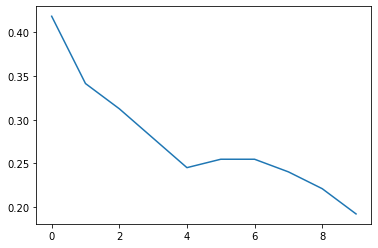

In [396]:
plt.plot(train_loss)

In [401]:
hamming_loss(np.round(dnn(doc2vec_array).numpy()), labels)

0.19230769230769232

##### Frequency Vectors

In [1080]:
word_freq_vectors['JC_Doc1_AI-Artificial-Intelligence.docx'].shape

(234,)

In [1094]:
freq_floors = [1]
n_rand = 5
results_f = defaultdict()


for ffloor in tqdm(freq_floors):
    results_f[ffloor] = defaultdict()
    for n in range(n_rand):
        # Init the results dict...
        results_f[ffloor][n] = defaultdict()
        
        # Now for the k-fold...
        for k in range(len(folds)):
            results_f[ffloor][n][k] = defaultdict()

            # Now making the freq vectors
#             vocab = defaultdict()
#             for doc in tokens_dict.keys():
# #                 vocab[doc] = [k for k, v in tokens_dict[doc].items() if v >= ffloor]
#                 vocab[doc] = tokens_dict[doc]

#             vocab_list = list()

#             for doc in vocab.keys():
#                 for word in vocab[doc]:
#                     vocab_list.append(word)

#             vocab_list = list(np.unique(vocab_list))
#             word_freq_vectors = defaultdict()

#             for doc in vocab.keys():
#                 word_freq_vectors[doc] = np.zeros(len(vocab_list))

#                 for word in tokens_dict[doc]:
#                     try:
#                         word_idx = vocab_list.index(word)
#                         word_freq_vectors[doc][word_idx] += 1
#                     except:
#                         continue

#             X_freq = list()

#             for doc in tokens_dict.keys():
#                 X_freq.append(word_freq_vectors[doc])

#             X_freq = np.array(X_freq)
            
            # Now we can draw out the training/testing using this fold's idxs
            X_test_freq = np.array([v for q, v in word_freq_vectors.items() if q in folds[k]['docs']])
            y_test_freq = labels[folds[k]['idxs']]

#             X_train_freq = [v for k, v in word_freq_vectors.items()][[x for x in range(len(tokens_dict)) if x not in folds[k]['idxs']]]
            X_train_freq = np.array([v for q, v in word_freq_vectors.items() if not q in folds[k]['docs']])
            y_train_freq = labels[[x for x in range(len(tokens_dict)) if x not in folds[k]['idxs']]]

            class DNN(tf.keras.Model):

                def __init__(self):
                    super(DNN, self).__init__()

                    self.l1 = tf.keras.layers.Dense(input_shape=(X_test_freq.shape[0], X_test_freq[1]),
                                                    units=128,
                                                    activation='relu',
                                                    kernel_initializer='glorot_uniform')
                    self.l2 = tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='glorot_uniform')

                def call(self, x):
                    x = self.l1(x)
                    return self.l2(x)
                
            dnn = DNN()
            loss_object = tf.keras.losses.BinaryCrossentropy()
            optimizer = tf.keras.optimizers.Adam()
            
            @tf.function
            def train_step(xdata, labels):
                with tf.GradientTape() as tape:
                    predictions = dnn(xdata)
                    loss = loss_object(labels, predictions)
                gradients = tape.gradient(loss, dnn.trainable_variables)
                optimizer.apply_gradients(zip(gradients, dnn.trainable_variables))
                
            EPOCHS = 50
            train_loss = list()
            test_loss = list()
            
            for epoch in range(EPOCHS):
                train_step(xdata=X_train_freq, labels=y_train_freq)
                train_loss.append(hamming_loss(y_true=y_train_freq, y_pred=np.round(dnn(X_train_freq).numpy())))
                test_loss.append(hamming_loss(y_true=y_test_freq, y_pred=np.round(dnn(X_test_freq).numpy())))
#             print(np.sum([np.prod(v.get_shape().as_list()) for v in dnn.trainable_weights]))                     
            results_f[ffloor][n][k]['train_loss'] = train_loss
            results_f[ffloor][n][k]['test_loss'] = test_loss

100%|██████████| 1/1 [01:34<00:00, 94.30s/it]


In [1095]:
results_f_agg = defaultdict()
# vsize --> n_rand --> k-fold
for v_size in results_f.keys():
    results_f_agg[v_size] = defaultdict()
    
    for n_rand_ in results_f[v_size].keys():
        results_f_agg[v_size][n_rand_] = defaultdict()
        fold_holder_train = list()
        fold_holder_test = list()
        
        for k_fold_ in results_f[v_size][n_rand_].keys():
            fold_holder_train.append(results_f[v_size][n_rand_][k_fold_]['train_loss'])
            fold_holder_test.append(results_f[v_size][n_rand_][k_fold_]['test_loss'])
            
        fold_train_performance = np.mean(np.array(fold_holder_train), axis=0)
        fold_test_performance = np.mean(np.array(fold_holder_test), axis=0)
        
        results_f_agg[v_size][n_rand_]['train_loss'] = fold_train_performance
        results_f_agg[v_size][n_rand_]['test_loss'] = fold_test_performance

In [830]:
seeds_1 = results_f_agg[1].keys()
seeds_2 = results_f_agg[2].keys()
seeds_3 = results_f_agg[3].keys()
seeds_4 = results_f_agg[4].keys()
seeds_5 = results_f_agg[5].keys()

Text(0, 0.5, 'Hamming Loss')

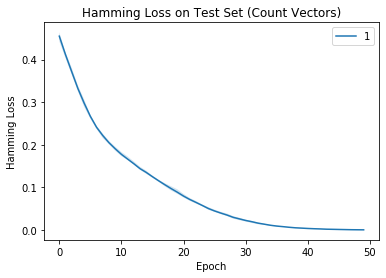

In [1097]:
train_loss_man = np.array([results_f_agg[1][x]['train_loss'] for x in range(5)])
test_loss_man = np.array([results_f_agg[1][x]['test_loss'] for x in range(5)])
# freq3 = np.array([results_f_agg[3][x]['test_loss'] for x in range(5)])
# freq4 = np.array([results_f_agg[4][x]['test_loss'] for x in range(5)])
# freq5 = np.array([results_f_agg[5][x]['test_loss'] for x in range(5)])

plt.plot(np.mean(train_loss_man, axis=0))
plt.fill_between([x for x in range(50)], np.min(train_loss_man, axis=0), np.max(train_loss_man, axis=0), alpha=0.2)

# plt.plot(np.mean(freq2, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq2, axis=0), np.max(freq2, axis=0), alpha=0.2)

# plt.plot(np.mean(freq3, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq3, axis=0), np.max(freq3, axis=0), alpha=0.2)

# plt.plot(np.mean(freq4, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq4, axis=0), np.max(freq4, axis=0), alpha=0.2)

# plt.plot(np.mean(freq5, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq5, axis=0), np.max(freq5, axis=0), alpha=0.2)

plt.legend([str(x) for x in freq_floors])
plt.title('Hamming Loss on Test Set (Count Vectors)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
# plt.savefig('./results/nn_fq_test.png', dpi=400)

In [907]:
# Measuring sparsity
for ffloor in tqdm(freq_floors):
    # Now making the freq vectors
    vocab = defaultdict()
    for doc in tokens_dict.keys():
        vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= ffloor]

    vocab_list = list()

    for doc in vocab.keys():
        for word in vocab[doc]:
            vocab_list.append(word)

    vocab_list = list(np.unique(vocab_list))
    word_freq_vectors = defaultdict()

    for doc in vocab.keys():
        word_freq_vectors[doc] = np.zeros(len(vocab_list))

        for word in tokens_dict[doc]['tokens']:
            try:
                word_idx = vocab_list.index(word)
                word_freq_vectors[doc][word_idx] += 1
            except:
                continue

    X_freq = list()

    for doc in tokens_dict.keys():
        X_freq.append(word_freq_vectors[doc])

    X_freq = np.array(X_freq)

#     print(X_freq.shape)
    
    sparse = 0
    for row in X_freq:
        sparse += len([x for x in row if x == 0])
        
    print(f'{X_freq.shape[1]}:{sparse / (X_freq.shape[0] * X_freq.shape[1])}')

100%|██████████| 5/5 [00:00<00:00, 16.88it/s]

3242:0.9332676885113652
587:0.8667933429432577
194:0.8197858842188739
86:0.789355992844365
50:0.7423076923076923


In [916]:
# Measuring sparsity
vec_size = [50, 86, 194, 587, 3242]
for vs in tqdm(vec_size):
    # Now making the freq vectors
    doc2vec_corpus = list()

    for doc in tokens_dict.keys():
        doc2vec_corpus.append(tokens_dict[doc]['tokens'])

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]
    model = Doc2Vec(documents, vector_size=vs, window=3, min_count=1, workers=16, seed=111, epochs=500)

    doc2vec_array = list()

    for doc in doc2vec_corpus:
        doc2vec_array.append(model.infer_vector(doc))

    doc2vec_array = np.array(doc2vec_array)
    doc2vec_array = MinMaxScaler().fit_transform(doc2vec_array)
    
    sparse = 0
    for row in doc2vec_array:
        sparse += len([x for x in row if x == 0])
        
    print(f'{doc2vec_array.shape[1]}:{sparse / (doc2vec_array.shape[0] * doc2vec_array.shape[1])}')

 20%|██        | 1/5 [00:14<00:58, 14.56s/it]

50:0.038461538461538464


 40%|████      | 2/5 [00:30<00:44, 14.94s/it]

86:0.038461538461538464


 60%|██████    | 3/5 [00:50<00:32, 16.36s/it]

194:0.038461538461538464


 80%|████████  | 4/5 [01:30<00:23, 23.51s/it]

587:0.038461538461538464


100%|██████████| 5/5 [03:49<00:00, 45.92s/it]

3242:0.038461538461538464


In [913]:
X_freq[0]

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 3.,
       0., 0., 7., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0.])

In [914]:
X_tfidf[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1015556 ,
       0.        , 0.        , 0.        , 0.07535213, 0.15867027,
       0.        , 0.        , 0.        , 0.        , 0.95336292,
       0.04071302, 0.        , 0.        , 0.        , 0.04071302,
       0.        , 0.        , 0.        , 0.        , 0.07846068,
       0.        , 0.        , 0.06543381, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12086665, 0.        , 0.        , 0.        ,
       0.        , 0.05313167, 0.        , 0.13691943, 0.        ])

In [915]:
tokens_dict[doc]['tokens']

['enjoyable',
 'movie',
 'ive',
 'seen',
 'far',
 '2013',
 'overwhelming',
 'blockbuster',
 'summer',
 'overhyped',
 'excitement',
 'followed',
 'mild',
 'severe',
 'disappointment',
 'monster',
 'university',
 'isnt',
 'good',
 'sign',
 'pixar',
 'good',
 'sign',
 '2013',
 'one',
 'best',
 'year',
 'film',
 'review',
 'story',
 'origin',
 'friendship',
 'oneeyed',
 'mike',
 'wazowski',
 'blue',
 'furred',
 'james',
 'p',
 'sullivan',
 'freshman',
 'year',
 'monster',
 'university',
 'film',
 'homage',
 'classic',
 'college',
 'comedy',
 'movie',
 'doesnt',
 'hold',
 'laugh',
 'kid',
 'adult',
 'great',
 'amount',
 'heart',
 'question',
 'future',
 'hold',
 'dream',
 'possible',
 'hope',
 'punch',
 'arent',
 'pulled',
 'question',
 'isnt',
 'animated',
 'movie',
 'take',
 'kid',
 'see',
 'reference',
 'real',
 'college',
 'life',
 'blended',
 'superb',
 'imagination',
 'monster',
 'world',
 'rather',
 'long',
 'blonde',
 'haired',
 'guitar',
 'player',
 'horn',
 'school',
 'bus',
 'ori

##### TF-IDF Vectors

In [1040]:
freq_floors = [1]
n_rand = 1
results_tf = defaultdict()


for ffloor in freq_floors:
    results_tf[ffloor] = defaultdict()
    for n in tqdm(range(n_rand)):
        # Init the results dict...
        results_tf[ffloor][n] = defaultdict()
        
        for k in range(len(folds)):
            results_tf[ffloor][n][k] = defaultdict()

            # Re-creating the vocabulary
            vocab = defaultdict()
            for doc in tokens_dict.keys():
#                 vocab[doc] = [k for k, v in tokens_dict[doc]['token_cnt'].items() if v >= ffloor]
                vocab[doc] = tokens_dict[doc]
                

            vocab_list = list()

            for doc in vocab.keys():
                for word in vocab[doc]:
                    vocab_list.append(word)

            vocab_list = list(np.unique(vocab_list))

#             results_tf[ffloor]['vocab_size'] = len(vocab_list)
#             results_tf[ffloor]['vocan'] = vocab_list

            # Now making the tf-idf vectors
            corpus_list = list()

            for doc in tokens_dict.keys():
                corpus_list.append(' '.join(tokens_dict[doc]))
#                 corpus_list.append(' '.join(tokens_dict[doc]['tokens']))

            tfidf = TfidfVectorizer(vocabulary=vocab_list)
            X = tfidf.fit_transform(corpus_list)
            X_tfidf = list()

            for doc in range(len(tokens_dict.keys())):
                X_tfidf.append(X.toarray()[doc])

            X_tfidf = np.array(X_tfidf)
            
            # Now we can draw out the training/testing using this fold's idxs
            X_test_tf = X_tfidf[folds[k]['idxs']]
            y_test_tf = labels[folds[k]['idxs']]

            X_train_tf = X_tfidf[[x for x in range(len(tokens_dict)) if x not in folds[k]['idxs']]]
            y_train_tf = labels[[x for x in range(len(tokens_dict)) if x not in folds[k]['idxs']]]

# #             print(X_test_tf)
# #             print(y_test_tf)
# #             print(X_train_tf.shape)

            class DNN(tf.keras.Model):

                def __init__(self):
                    super(DNN, self).__init__()

                    self.l1 = tf.keras.layers.Dense(input_shape=(X_test_tf.shape[0], X_test_tf[1]),
                                                    units=128,
                                                    activation='relu',
                                                    kernel_initializer='glorot_uniform')
                    self.l2 = tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='glorot_uniform')

                def call(self, x):
                    x = self.l1(x)
                    return self.l2(x)
            # TRAINING LOOP
            dnn = DNN()
            loss_object = tf.keras.losses.BinaryCrossentropy()
            optimizer = tf.keras.optimizers.Adam()

            @tf.function
            def train_step(xdata, labels):

                with tf.GradientTape() as tape:

                    predictions = dnn(xdata)
                    loss = loss_object(labels, predictions)

                gradients = tape.gradient(loss, dnn.trainable_variables)
                optimizer.apply_gradients(zip(gradients, dnn.trainable_variables))


            EPOCHS = 2
#             train_loss = list()
#             test_loss = list()
            
            for epoch in range(EPOCHS):
                train_step(xdata=X_train_tf, labels=y_train_tf)
#                 train_loss.append(hamming_loss(y_true=y_train_tf, y_pred=np.round(dnn(X_train_tf).numpy())))
#                 test_loss.append(hamming_loss(y_true=y_test_tf, y_pred=np.round(dnn(X_test_tf).numpy())))
            print(np.sum([np.prod(v.get_shape().as_list()) for v in dnn.trainable_weights]))                 
#             results_tf[ffloor][n][k]['train_loss'] = train_loss
#             results_tf[ffloor][n][k]['test_loss'] = test_loss

  0%|          | 0/1 [00:00<?, ?it/s]

878216
878216
878216
878216
878216
878216
878216
878216
878216
878216
878216
878216
878216
878216
878216


100%|██████████| 1/1 [00:07<00:00,  7.78s/it]

878216


In [1073]:
X_tfidf.shape

(64, 6852)

In [1057]:
tfidf.vocabulary

['',
 '1',
 '10',
 '100',
 '1000page',
 '1000plus',
 '1010',
 '10second',
 '11',
 '118',
 '12',
 '1227',
 '12th',
 '12yearold',
 '12yearolds',
 '13',
 '1492',
 '15',
 '163',
 '17yearold',
 '1926',
 '1940s',
 '1942',
 '1954',
 '1957',
 '1960s',
 '1961',
 '1968',
 '1969',
 '1970s',
 '1976',
 '1980s',
 '1982',
 '1986',
 '1987',
 '1994',
 '1994’s',
 '1½”',
 '2',
 '20',
 '200000',
 '2001',
 '2003',
 '2004',
 '2005',
 '2007',
 '2009',
 '2010',
 '2013',
 '2014',
 '2015',
 '2016',
 '2016’s',
 '2017’s',
 '2019',
 '2020',
 '2049',
 '2049”',
 '20th',
 '21',
 '21st',
 '21stcentury',
 '23',
 '23yearold',
 '25',
 '26',
 '2d',
 '2”',
 '3',
 '33',
 '3d',
 '4',
 '400',
 '48',
 '48fps',
 '5',
 '50',
 '500',
 '59735548',
 '5yearold',
 '6',
 '7',
 '76th',
 '77th',
 '80',
 '88',
 '9',
 '90minute',
 '98',
 'abandon',
 'abandoned',
 'abe',
 'abides',
 'ability',
 'able',
 'abound',
 'aboveaverage',
 'abraham',
 'abrupt',
 'abruptly',
 'absolutely',
 'absorb',
 'absurd',
 'absurdity',
 'abuelita',
 'abuse',
 

In [1062]:
vocab_idx = defaultdict()

for w in terms:
    for t in w:
        try:
            vocab_idx[t] = tfidf.vocabulary.index(t)
        except:
            continue

In [1063]:
vocab_idx

defaultdict(None,
            {'human': 2991,
             'ai': 199,
             'emotion': 2005,
             'advanced': 163,
             'computer': 1244,
             'action': 134,
             'scifi': 5240,
             'suspense': 5895,
             'horror': 2961,
             'fun': 2503,
             'noir': 4124,
             'director': 1723,
             'dark': 1522,
             'love': 3638,
             'classic': 1093,
             'heart': 2857,
             'kid': 3370,
             'dream': 1853,
             'surprising': 5885,
             'sky': 5490,
             'color': 1175,
             'blade': 674,
             'short': 5394,
             'rain': 4796,
             'news': 4104,
             'comedy': 1186,
             'competition': 1222,
             'laugh': 3463,
             'game': 2538,
             'sport': 5655,
             'coach': 1127,
             'little': 3584,
             'team': 5964,
             'newsroom': 4105,
             'at

In [1065]:
vocab_scores = defaultdict()

for t in vocab_idx.keys():
    idx = vocab_idx[t]
    werd = list()
    for vector in X_tfidf:
        werd.append(vector[idx])
        
    vocab_scores[t] = np.mean(werd)

In [1066]:
vocab_scores

defaultdict(None,
            {'human': 0.019077296137348716,
             'ai': 0.002965739994278711,
             'emotion': 0.00563483545364923,
             'advanced': 0.002965739994278711,
             'computer': 0.005930665311041821,
             'action': 0.019177762049589295,
             'scifi': 0.009970286157552043,
             'suspense': 0.004362605375953194,
             'horror': 0.007787676684095199,
             'fun': 0.0073080817534772365,
             'noir': 0.0035661514638530823,
             'director': 0.013610451005766671,
             'dark': 0.008572791446279416,
             'love': 0.014116372182423332,
             'classic': 0.008466239869147239,
             'heart': 0.010063767011986632,
             'kid': 0.01738276929131598,
             'dream': 0.009095687985861863,
             'surprising': 0.00340577941163887,
             'sky': 0.001860041536846462,
             'color': 0.007362195437769423,
             'blade': 0.02163667300136543,
     

In [1067]:
all_tfidf = list()

for vector in X_tfidf:
    for w in vector:
        all_tfidf.append(w)

In [1072]:
print(np.mean(all_tfidf))
print(np.median(all_tfidf))

print(np.mean([v for k, v in vocab_scores.items()]))
print(np.median([v for k, v in vocab_scores.items()]))

0.0019098592045710774
0.0
0.007174711117327187
0.0061206569313193805


In [1102]:
all_tfidf.shape

AttributeError: 'list' object has no attribute 'shape'

Text(0, 0.5, 'Hamming Loss')

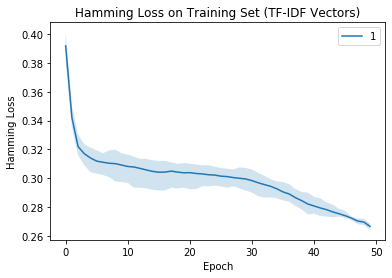

In [980]:
results_tf_agg = defaultdict()
# vsize --> n_rand --> k-fold
for v_size in results_tf.keys():
    results_tf_agg[v_size] = defaultdict()
    
    for n_rand_ in results_tf[v_size].keys():
        results_tf_agg[v_size][n_rand_] = defaultdict()
        fold_holder_train = list()
        fold_holder_test = list()
        
        for k_fold_ in results_tf[v_size][n_rand_].keys():
            fold_holder_train.append(results_tf[v_size][n_rand_][k_fold_]['train_loss'])
            fold_holder_test.append(results_tf[v_size][n_rand_][k_fold_]['test_loss'])
            
        fold_train_performance = np.mean(np.array(fold_holder_train), axis=0)
        fold_test_performance = np.mean(np.array(fold_holder_test), axis=0)
        
        results_tf_agg[v_size][n_rand_]['train_loss'] = fold_train_performance
        results_tf_agg[v_size][n_rand_]['test_loss'] = fold_test_performance
        
# seeds_1 = results_tf_agg[1].keys()
# seeds_2 = results_tf_agg[2].keys()
# seeds_3 = results_tf_agg[3].keys()
# seeds_4 = results_tf_agg[4].keys()
# seeds_5 = results_tf_agg[5].keys()

train_loss_tf = np.array([results_tf_agg[1][x]['train_loss'] for x in range(5)])
test_loss_tf = np.array([results_tf_agg[1][x]['test_loss'] for x in range(5)])
# freq2_tf = np.array([results_tf_agg[2][x]['test_loss'] for x in range(5)])
# freq3 = np.array([results_tf_agg[3][x]['test_loss'] for x in range(5)])
# freq4 = np.array([results_tf_agg[4][x]['test_loss'] for x in range(5)])
# freq5 = np.array([results_tf_agg[5][x]['test_loss'] for x in range(5)])

plt.plot(np.mean(test_loss_tf, axis=0))
plt.fill_between([x for x in range(50)], np.min(test_loss_tf, axis=0), np.max(test_loss_tf, axis=0), alpha=0.2)

# plt.plot(np.mean(freq2, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq2, axis=0), np.max(freq2, axis=0), alpha=0.2)

# plt.plot(np.mean(freq3, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq3, axis=0), np.max(freq3, axis=0), alpha=0.2)

# plt.plot(np.mean(freq4, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq4, axis=0), np.max(freq4, axis=0), alpha=0.2)

# plt.plot(np.mean(freq5, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq5, axis=0), np.max(freq5, axis=0), alpha=0.2)

plt.legend([str(x) for x in freq_floors])
plt.title('Hamming Loss on Training Set (TF-IDF Vectors)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
# plt.savefig('./results/nn_tf_train.png', dpi=400)

##### doc2vec Vectors

In [1041]:
vec_size = [500]

n_rand = 5
results_dv = defaultdict()

for vs in vec_size:
    results_dv[vs] = defaultdict()
    
    for n in tqdm(range(n_rand)):
        # Init the results dict...
        results_dv[vs][n] = defaultdict()
        
        for k in range(len(folds)):
            results_dv[vs][n][k] = defaultdict()
            
            # Re-creating the vocabulary
            doc2vec_corpus = list()

            for doc in tokens_dict.keys():
#                 doc2vec_corpus.append(tokens_dict[doc]['tokens'])
                doc2vec_corpus.append(tokens_dict[doc])

            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]
            model = Doc2Vec(documents, vector_size=vs, window=3, min_count=1, workers=16, seed=111, epochs=1)

            doc2vec_array = list()

            for doc in doc2vec_corpus:
                doc2vec_array.append(model.infer_vector(doc))

            doc2vec_array = np.array(doc2vec_array)
            doc2vec_array = MinMaxScaler().fit_transform(doc2vec_array)
            
            # Now we can draw out the training/testing using this fold's idxs
            X_test_dv = doc2vec_array[folds[k]['idxs']]
            y_test_dv = labels[folds[k]['idxs']]

            X_train_dv = doc2vec_array[[x for x in range(len(tokens_dict)) if x not in folds[k]['idxs']]]
            y_train_dv = labels[[x for x in range(len(tokens_dict)) if x not in folds[k]['idxs']]]
            
            class DNN(tf.keras.Model):

                def __init__(self):
                    super(DNN, self).__init__()

                    self.l1 = tf.keras.layers.Dense(input_shape=(doc2vec_array.shape[0], doc2vec_array[1]),
                                                    units=128,
                                                    activation='relu',
                                                    kernel_initializer='glorot_uniform')
                    self.l2 = tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='glorot_uniform')

                def call(self, x):
                    x = self.l1(x)
                    return self.l2(x)
                
            # TRAINING LOOP
            dnn = DNN()
            loss_object = tf.keras.losses.BinaryCrossentropy()
            optimizer = tf.keras.optimizers.Adam()

            @tf.function
            def train_step(xdata, labels):

                with tf.GradientTape() as tape:

                    predictions = dnn(xdata)
                    loss = loss_object(labels, predictions)

                gradients = tape.gradient(loss, dnn.trainable_variables)
                optimizer.apply_gradients(zip(gradients, dnn.trainable_variables))

            EPOCHS = 2
            train_loss = list()
            test_loss = list()
            
            for epoch in range(EPOCHS):
                train_step(xdata=X_train_dv, labels=y_train_dv)
#                 train_loss.append(hamming_loss(y_true=y_train_dv, y_pred=np.round(dnn(X_train_dv).numpy())))
#                 test_loss.append(hamming_loss(y_true=y_test_dv, y_pred=np.round(dnn(X_test_dv).numpy())))
            print(np.sum([np.prod(v.get_shape().as_list()) for v in dnn.trainable_weights]))         
#             results_dv[vs][n][k]['train_loss'] = train_loss
#             results_dv[vs][n][k]['test_loss'] = test_loss

  0%|          | 0/5 [00:00<?, ?it/s]

65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160


 20%|██        | 1/5 [00:29<01:59, 29.78s/it]

65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160


 40%|████      | 2/5 [00:57<01:27, 29.15s/it]

65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160


 60%|██████    | 3/5 [01:24<00:57, 28.57s/it]

65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160


 80%|████████  | 4/5 [01:52<00:28, 28.48s/it]

65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160
65160


 80%|████████  | 4/5 [02:17<00:34, 34.45s/it]


KeyboardInterrupt: 

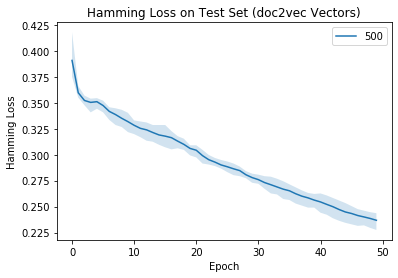

In [989]:
results_dv_agg = defaultdict()
# vsize --> n_rand --> k-fold
for v_size in results_dv.keys():
    results_dv_agg[v_size] = defaultdict()
    
    for n_rand_ in results_dv[v_size].keys():
        results_dv_agg[v_size][n_rand_] = defaultdict()
        fold_holder_train = list()
        fold_holder_test = list()
        
        for k_fold_ in results_dv[v_size][n_rand_].keys():
            fold_holder_train.append(results_dv[v_size][n_rand_][k_fold_]['train_loss'])
            fold_holder_test.append(results_dv[v_size][n_rand_][k_fold_]['test_loss'])
            
        fold_train_performance = np.mean(np.array(fold_holder_train), axis=0)
        fold_test_performance = np.mean(np.array(fold_holder_test), axis=0)
        
        results_dv_agg[v_size][n_rand_]['train_loss'] = fold_train_performance
        results_dv_agg[v_size][n_rand_]['test_loss'] = fold_test_performance

# seeds_1 = results_dv_agg[50].keys()
# seeds_2 = results_dv_agg[86].keys()
# seeds_3 = results_dv_agg[194].keys()
# seeds_4 = results_dv_agg[587].keys()
# seeds_5 = results_dv_agg[3242].keys()

test_loss_dv = np.array([results_dv_agg[500][x]['test_loss'] for x in range(5)])
train_loss_dv = np.array([results_dv_agg[500][x]['train_loss'] for x in range(5)])
# freq2 = np.array([results_dv_agg[86][x]['test_loss'] for x in range(5)])
# freq3 = np.array([results_dv_agg[194][x]['test_loss'] for x in range(5)])
# freq4 = np.array([results_dv_agg[587][x]['test_loss'] for x in range(5)])
# freq5 = np.array([results_dv_agg[3242][x]['test_loss'] for x in range(5)])

plt.plot(np.mean(test_loss_dv, axis=0))
plt.fill_between([x for x in range(50)], np.min(test_loss_dv, axis=0), np.max(test_loss_dv, axis=0), alpha=0.2)

# plt.plot(np.mean(freq2, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq2, axis=0), np.max(freq2, axis=0), alpha=0.2)

# plt.plot(np.mean(freq3, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq3, axis=0), np.max(freq3, axis=0), alpha=0.2)

# plt.plot(np.mean(freq4, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq4, axis=0), np.max(freq4, axis=0), alpha=0.2)

# plt.plot(np.mean(freq5, axis=0))
# plt.fill_between([x for x in range(25)], np.min(freq5, axis=0), np.max(freq5, axis=0), alpha=0.2)

plt.legend([str(x) for x in vec_size])
plt.title('Hamming Loss on Test Set (doc2vec Vectors)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.savefig('./results/nn_dv_test.png', dpi=400)

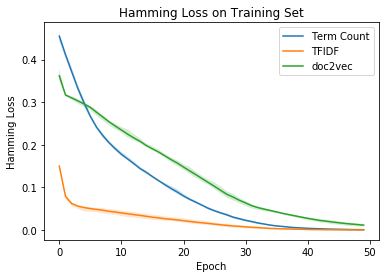

In [1103]:
plt.plot(np.mean(train_loss_man, axis=0))
plt.fill_between([x for x in range(50)], np.min(train_loss_man, axis=0), np.max(train_loss_man, axis=0), alpha=0.2)
plt.plot(np.mean(train_loss_tf, axis=0))
plt.fill_between([x for x in range(50)], np.min(train_loss_tf, axis=0), np.max(train_loss_tf, axis=0), alpha=0.2)
plt.plot(np.mean(train_loss_dv, axis=0))
plt.fill_between([x for x in range(50)], np.min(train_loss_dv, axis=0), np.max(train_loss_dv, axis=0), alpha=0.2)

plt.title('Hamming Loss on Training Set')
plt.ylabel('Hamming Loss')
plt.xlabel('Epoch')
plt.legend(['Term Count', 'TFIDF', 'doc2vec'])
plt.savefig('./results/comparison_train.png', dpi=400)

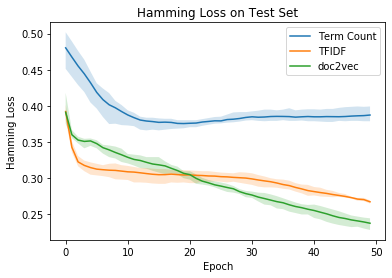

In [1104]:
plt.plot(np.mean(test_loss_man, axis=0))
plt.fill_between([x for x in range(50)], np.min(test_loss_man, axis=0), np.max(test_loss_man, axis=0), alpha=0.2)
plt.plot(np.mean(test_loss_tf, axis=0))
plt.fill_between([x for x in range(50)], np.min(test_loss_tf, axis=0), np.max(test_loss_tf, axis=0), alpha=0.2)
plt.plot(np.mean(test_loss_dv, axis=0))
plt.fill_between([x for x in range(50)], np.min(test_loss_dv, axis=0), np.max(test_loss_dv, axis=0), alpha=0.2)

plt.title('Hamming Loss on Test Set')
plt.ylabel('Hamming Loss')
plt.xlabel('Epoch')
plt.legend(['Term Count', 'TFIDF', 'doc2vec'])
plt.savefig('./results/comparison_test.png', dpi=400)

In [1107]:
(878216-65160)/878216

0.9258041301912058

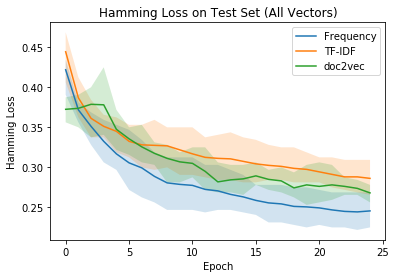

In [849]:


plt.plot(np.mean(freq1_fq, axis=0))
plt.fill_between([x for x in range(25)], np.min(freq1_fq, axis=0), np.max(freq1_fq, axis=0), alpha=0.2)

plt.plot(np.mean(freq1_tf, axis=0))
plt.fill_between([x for x in range(25)], np.min(freq1_tf, axis=0), np.max(freq1_tf, axis=0), alpha=0.2)

plt.plot(np.mean(freq5_dv, axis=0))
plt.fill_between([x for x in range(25)], np.min(freq5_dv, axis=0), np.max(freq5_dv, axis=0), alpha=0.2)
plt.legend(['Frequency', 'TF-IDF', 'doc2vec'])
plt.title('Hamming Loss on Test Set (All Vectors)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.savefig('./results/nn_compare_test.png', dpi=400)

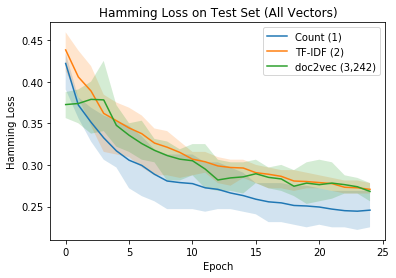

In [920]:
plt.plot(np.mean(freq1_fq, axis=0))
plt.fill_between([x for x in range(25)], np.min(freq1_fq, axis=0), np.max(freq1_fq, axis=0), alpha=0.2)

plt.plot(np.mean(freq2_tf, axis=0))
plt.fill_between([x for x in range(25)], np.min(freq2_tf, axis=0), np.max(freq2_tf, axis=0), alpha=0.2)

plt.plot(np.mean(freq5_dv, axis=0))
plt.fill_between([x for x in range(25)], np.min(freq5_dv, axis=0), np.max(freq5_dv, axis=0), alpha=0.2)
plt.legend(['Count (1)', 'TF-IDF (2)', 'doc2vec (3,242)'])
plt.title('Hamming Loss on Test Set (All Vectors)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.savefig('./results/nn_compare_test.png', dpi=400)

In [759]:
np.round(dnn(X_test_dv).numpy())

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [741]:
y_test_dv

array([[0, 0, 1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]])

# Counting number of learnable params

In [809]:
vec_size = [50, 86, 194, 587, 3242]

for vs in vec_size:
    # Re-creating the vocabulary
    doc2vec_corpus = list()

    for doc in tokens_dict.keys():
        doc2vec_corpus.append(tokens_dict[doc]['tokens'])

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_corpus)]
    model = Doc2Vec(documents, vector_size=vs, window=3, min_count=1, workers=16, seed=111, epochs=1)

    doc2vec_array = list()

    for doc in doc2vec_corpus:
        doc2vec_array.append(model.infer_vector(doc))

    doc2vec_array = np.array(doc2vec_array)
    doc2vec_array = MinMaxScaler().fit_transform(doc2vec_array)
    
    # Now we can draw out the training/testing using this fold's idxs
    X_test_dv = doc2vec_array[folds[k]['idxs']]
    y_test_dv = labels[folds[k]['idxs']]

    X_train_dv = doc2vec_array[[x for x in range(26) if x not in folds[k]['idxs']]]
    y_train_dv = labels[[x for x in range(26) if x not in folds[k]['idxs']]]
    
    class DNN(tf.keras.Model):
    
        def __init__(self):
            super(DNN, self).__init__()

            self.l1 = tf.keras.layers.Dense(input_shape=(doc2vec_array.shape[0], doc2vec_array[1]),
                                            units=128,
                                            activation='relu',
                                            kernel_initializer='glorot_uniform')
            self.l2 = tf.keras.layers.Dense(8, activation='sigmoid', kernel_initializer='glorot_uniform')

        def call(self, x):
            x = self.l1(x)
            return self.l2(x)
    dnn = DNN()
    loss_object = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    @tf.function
    def train_step(xdata, labels):

        with tf.GradientTape() as tape:

            predictions = dnn(xdata)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, dnn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, dnn.trainable_variables))

    EPOCHS = 2

    for epoch in range(EPOCHS):
        train_step(xdata=X_train_dv, labels=y_train_dv)
    
    print('============================================')
    print(doc2vec_array.shape[1])
#     print(dnn.summary())
    print(np.sum([np.prod(v.get_shape().as_list()) for v in dnn.trainable_weights]))

50
7560
86
12168
194
25992
587
76296
3242
416136


In [886]:
dead_cnt = 0
for layer in range(len(dnn.trainable_variables)):

    if len(dnn.trainable_weights[layer].numpy().shape) > 1:
        for row in dnn.trainable_weights[layer].numpy():
            dead_cnt += len([x for x in row if x == 0])
            
    else:
        dead_cnt += len([x for x in dnn.trainable_weights[layer].numpy() if x == 0])

In [887]:
dead_cnt

1

### Determining sparsity

In [1048]:
sparsity = 0
for vec in doc2vec_array:
    sparsity += len([x for x in vec if x == 0])
    
print(f'{sparsity / (doc2vec_array.shape[0] * doc2vec_array.shape[1])}')

0.015625


In [1050]:
sparsity = 0
for vec in X_tfidf:
    sparsity += len([x for x in vec if x == 0])
    
print(f'{sparsity / (X_tfidf.shape[0] * X_tfidf.shape[1])}')

0.9667957348219498


In [1092]:
all_wf = list()

for doc in word_freq_vectors.keys():
    all_wf.append(word_freq_vectors[doc])
    
all_wf = np.array(all_wf)

sparsity = 0
for vec in all_wf:
    sparsity += len([x for x in vec if x == 0])
print(f'{sparsity / (all_wf.shape[0] * all_wf.shape[1])}')

0.8829460470085471


In [1083]:
all_wf[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.